In [1]:

import numpy as np
import matplotlib.pyplot as plt
from models import StochasticVolatilityModel, generate_data
from filters import ExtendedKalmanFilter, UnscentedKalmanFilter, ParticleFilter

In [12]:
# Stochastic Volatility Model
# State: x (log-volatility, 1D)
# Observation: y (returns, 1D)
# Nonlinear observation: y = β·exp(x/2)·v

# Model parameters
alpha = 0.91
sigma = 1.0
beta = 0.5

# Create model and generate data
random_state = np.random.default_rng(42)
model_sv = StochasticVolatilityModel(alpha=alpha, sigma=sigma, beta=beta, random_state=random_state)
T = 5000
true_states_sv, observations_sv = generate_data(model_sv, T, random_state)

# Run filters
from filters import ExtendedKalmanFilter, UnscentedKalmanFilter, ParticleFilter

# EKF
ekf = ExtendedKalmanFilter(model_sv)
ekf_means, ekf_covs = ekf.filter(observations_sv)

# UKF
ukf = UnscentedKalmanFilter(model_sv)
ukf_means, ukf_covs = ukf.filter(observations_sv)

# PF
pf = ParticleFilter(model_sv, n_particles=1000)
pf_means, pf_covs = pf.filter(observations_sv, random_state=random_state)

# Compute errors for each filter
errors_ekf = ekf_means - true_states_sv
errors_ukf = ukf_means - true_states_sv
errors_pf = pf_means - true_states_sv

error_norms_ekf = np.linalg.norm(errors_ekf, axis=1)
error_norms_ukf = np.linalg.norm(errors_ukf, axis=1)
error_norms_pf = np.linalg.norm(errors_pf, axis=1)

uncertainty_norms_ekf = np.sqrt(np.trace(ekf_covs, axis1=1, axis2=2))
uncertainty_norms_ukf = np.sqrt(np.trace(ukf_covs, axis1=1, axis2=2))
uncertainty_norms_pf = np.sqrt(np.trace(pf_covs, axis1=1, axis2=2))

normalized_errors_ekf = error_norms_ekf / uncertainty_norms_ekf
normalized_errors_ukf = error_norms_ukf / uncertainty_norms_ukf
normalized_errors_pf = error_norms_pf / uncertainty_norms_pf

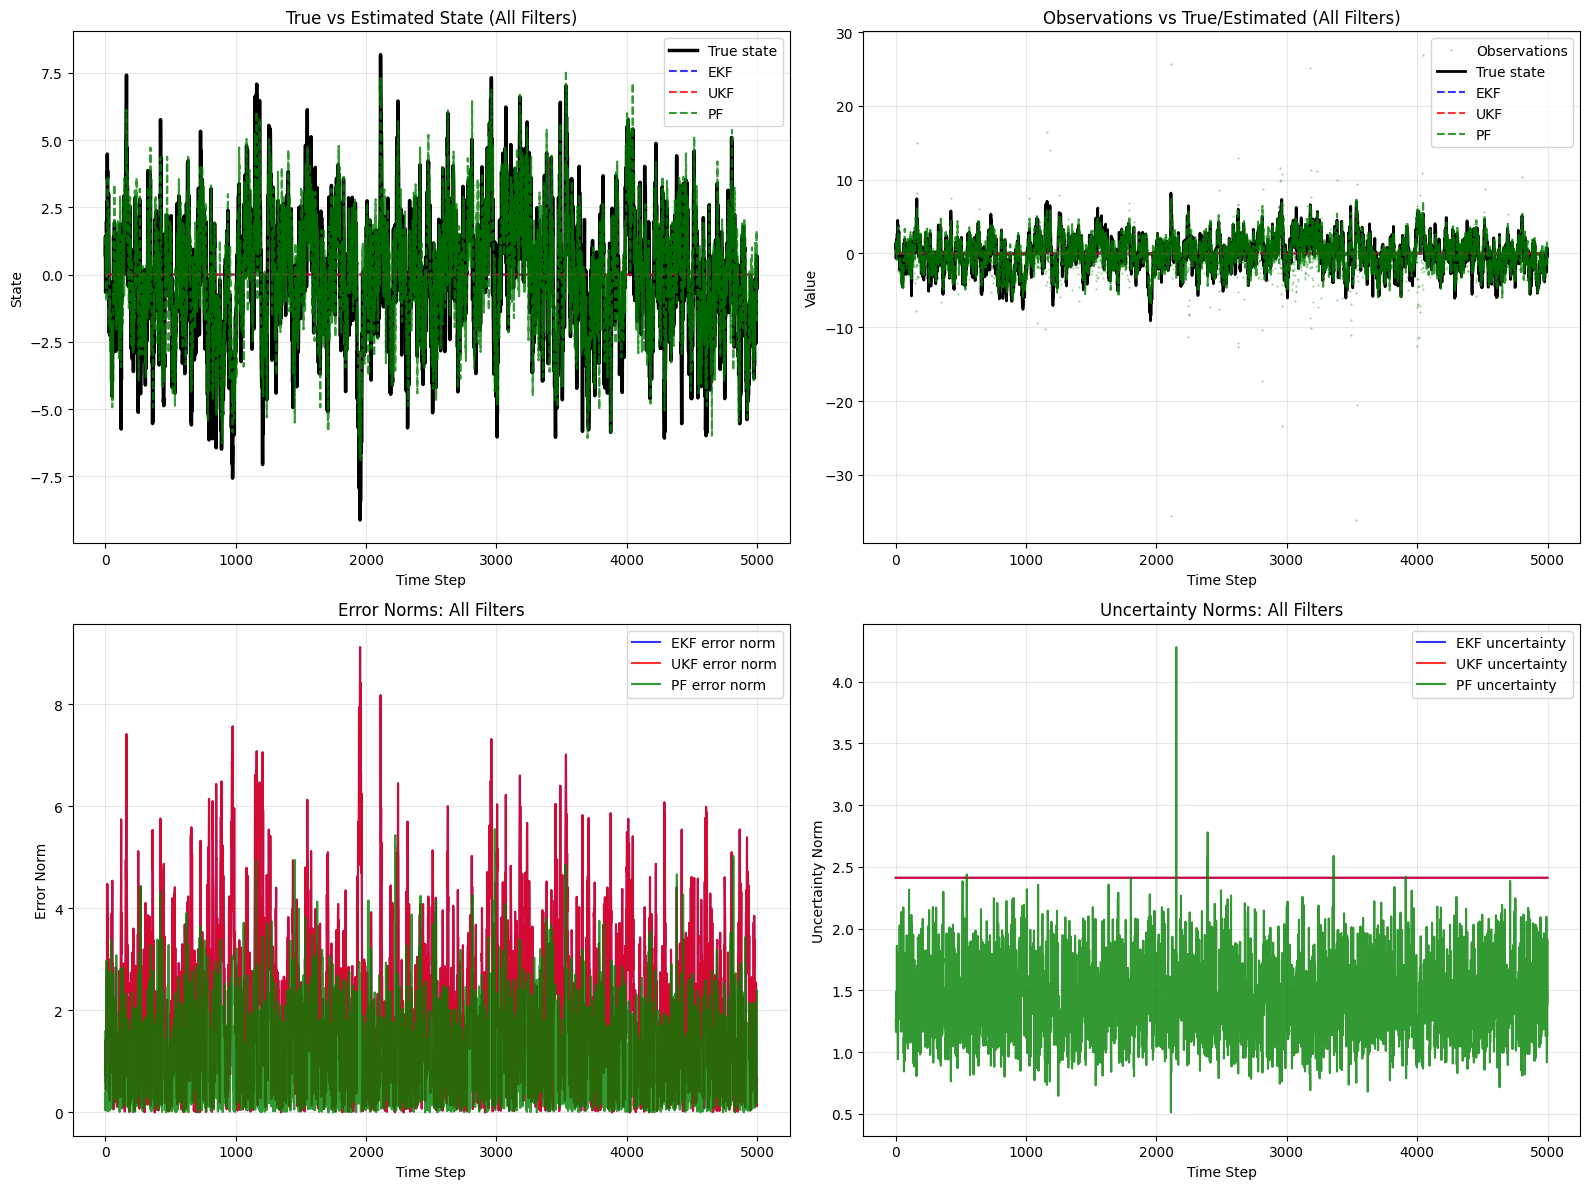

Summary Statistics:
EKF - Mean normalized error: 0.7979, Max: 3.7821
UKF - Mean normalized error: 0.7979, Max: 3.7821
PF  - Mean normalized error: 0.7510, Max: 3.6249


In [13]:
# Visualization: 4 plots with all 3 filters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
time_steps = np.arange(T)

# Plot 1: True vs Estimated (all 3 filters)
ax = axes[0, 0]
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2.5)
ax.plot(time_steps, ekf_means[:, 0], 'b--', label='EKF', linewidth=1.5, alpha=0.8)
ax.plot(time_steps, ukf_means[:, 0], 'r--', label='UKF', linewidth=1.5, alpha=0.8)
ax.plot(time_steps, pf_means[:, 0], 'g--', label='PF', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time Step')
ax.set_ylabel('State')
ax.set_title('True vs Estimated State (All Filters)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Observations vs True/Estimated
ax = axes[0, 1]
ax.plot(time_steps, observations_sv[:, 0], 'g.', label='Observations', markersize=1, alpha=0.4)
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2)
ax.plot(time_steps, ekf_means[:, 0], 'b--', label='EKF', linewidth=1.5, alpha=0.8)
ax.plot(time_steps, ukf_means[:, 0], 'r--', label='UKF', linewidth=1.5, alpha=0.8)
ax.plot(time_steps, pf_means[:, 0], 'g--', label='PF', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.set_title('Observations vs True/Estimated (All Filters)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Error norms (all 3 filters)
ax = axes[1, 0]
ax.plot(time_steps, error_norms_ekf, 'b-', linewidth=1.5, label='EKF error norm', alpha=0.8)
ax.plot(time_steps, error_norms_ukf, 'r-', linewidth=1.5, label='UKF error norm', alpha=0.8)
ax.plot(time_steps, error_norms_pf, 'g-', linewidth=1.5, label='PF error norm', alpha=0.8)
ax.set_xlabel('Time Step')
ax.set_ylabel('Error Norm')
ax.set_title('Error Norms: All Filters')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Uncertainty norms (all 3 filters)
ax = axes[1, 1]
ax.plot(time_steps, uncertainty_norms_ekf, 'b-', linewidth=1.5, label='EKF uncertainty', alpha=0.8)
ax.plot(time_steps, uncertainty_norms_ukf, 'r-', linewidth=1.5, label='UKF uncertainty', alpha=0.8)
ax.plot(time_steps, uncertainty_norms_pf, 'g-', linewidth=1.5, label='PF uncertainty', alpha=0.8)
ax.set_xlabel('Time Step')
ax.set_ylabel('Uncertainty Norm')
ax.set_title('Uncertainty Norms: All Filters')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("Summary Statistics:")
print(f"EKF - Mean normalized error: {np.mean(normalized_errors_ekf):.4f}, Max: {np.max(normalized_errors_ekf):.4f}")
print(f"UKF - Mean normalized error: {np.mean(normalized_errors_ukf):.4f}, Max: {np.max(normalized_errors_ukf):.4f}")
print(f"PF  - Mean normalized error: {np.mean(normalized_errors_pf):.4f}, Max: {np.max(normalized_errors_pf):.4f}")

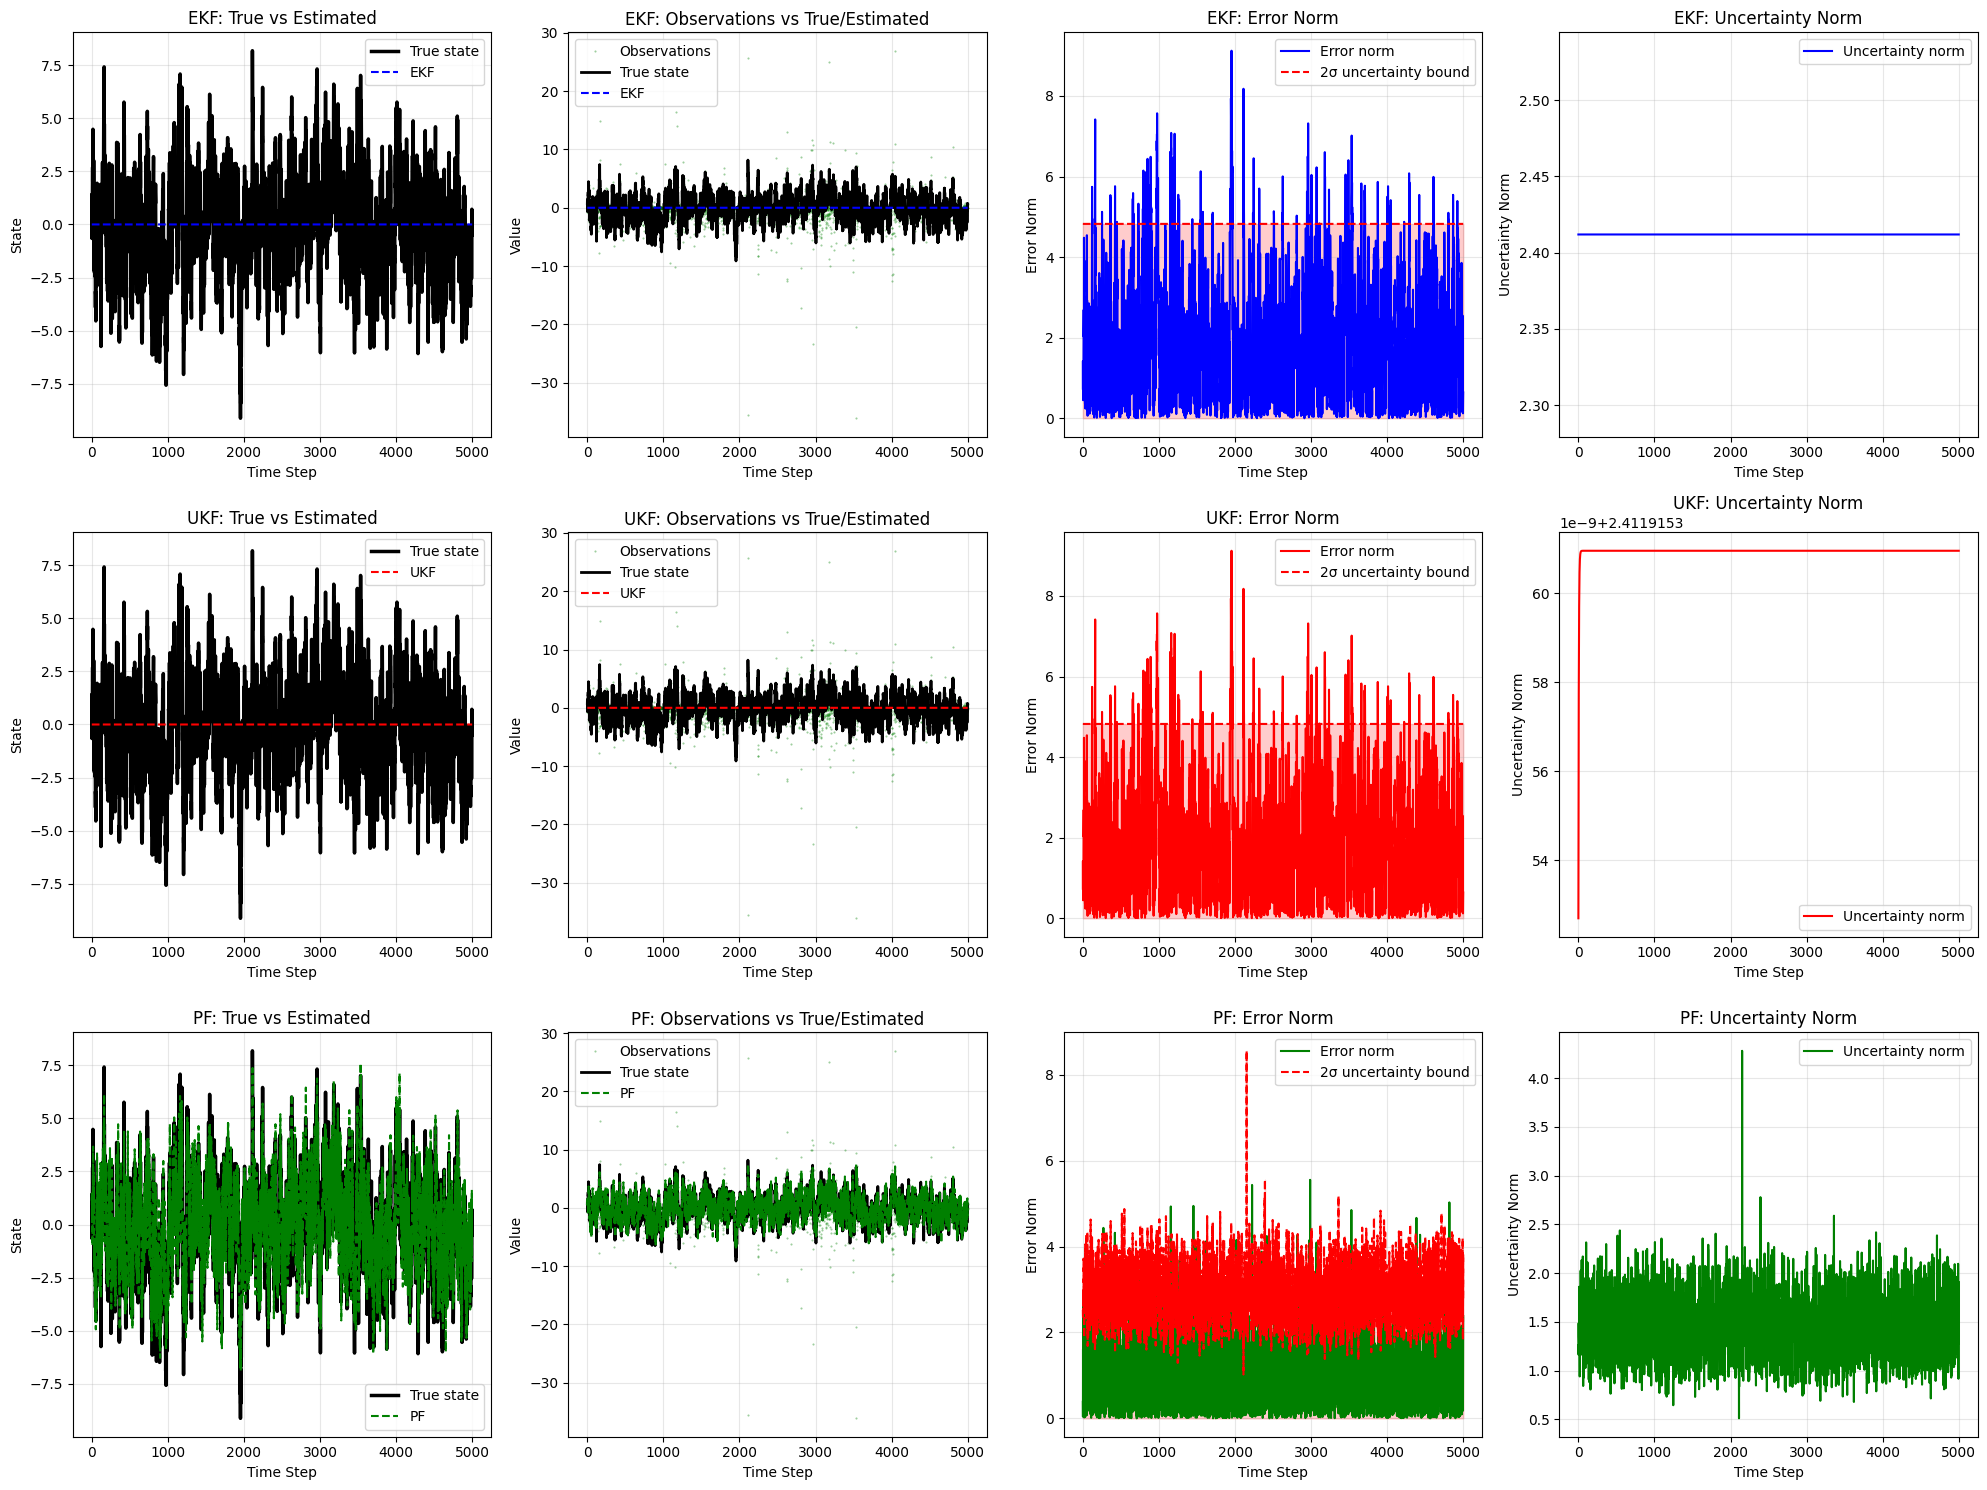

In [14]:
# Individual plots for each filter with 2σ confidence intervals
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
time_steps = np.arange(T)

# Compute standard deviations for each filter (1D state)
ekf_std = np.sqrt(ekf_covs[:, 0, 0])
ukf_std = np.sqrt(ukf_covs[:, 0, 0])
pf_std = np.sqrt(pf_covs[:, 0, 0])

# EKF plots
ax = axes[0, 0]
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2.5)
ax.plot(time_steps, ekf_means[:, 0], 'b--', label='EKF', linewidth=1.5)

ax.set_xlabel('Time Step')
ax.set_ylabel('State')
ax.set_title('EKF: True vs Estimated')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(time_steps, observations_sv[:, 0], 'g.', label='Observations', markersize=1, alpha=0.4)
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2)
ax.plot(time_steps, ekf_means[:, 0], 'b--', label='EKF', linewidth=1.5)

ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.set_title('EKF: Observations vs True/Estimated')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 2]
ax.plot(time_steps, error_norms_ekf, 'b-', linewidth=1.5, label='Error norm')
ax.plot(time_steps, 2*uncertainty_norms_ekf, 'r--', linewidth=1.5, label='2σ uncertainty bound')
ax.fill_between(time_steps, np.zeros(T), 2*uncertainty_norms_ekf, alpha=0.2, color='red')
ax.set_xlabel('Time Step')
ax.set_ylabel('Error Norm')
ax.set_title('EKF: Error Norm')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 3]
ax.plot(time_steps, uncertainty_norms_ekf, 'b-', linewidth=1.5, label='Uncertainty norm')
ax.set_xlabel('Time Step')
ax.set_ylabel('Uncertainty Norm')
ax.set_title('EKF: Uncertainty Norm')
ax.legend()
ax.grid(True, alpha=0.3)

# UKF plots
ax = axes[1, 0]
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2.5)
ax.plot(time_steps, ukf_means[:, 0], 'r--', label='UKF', linewidth=1.5)

ax.set_xlabel('Time Step')
ax.set_ylabel('State')
ax.set_title('UKF: True vs Estimated')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(time_steps, observations_sv[:, 0], 'g.', label='Observations', markersize=1, alpha=0.4)
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2)
ax.plot(time_steps, ukf_means[:, 0], 'r--', label='UKF', linewidth=1.5)

ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.set_title('UKF: Observations vs True/Estimated')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
ax.plot(time_steps, error_norms_ukf, 'r-', linewidth=1.5, label='Error norm')
ax.plot(time_steps, 2*uncertainty_norms_ukf, 'r--', linewidth=1.5, label='2σ uncertainty bound')
ax.fill_between(time_steps, np.zeros(T), 2*uncertainty_norms_ukf, alpha=0.2, color='red')
ax.set_xlabel('Time Step')
ax.set_ylabel('Error Norm')
ax.set_title('UKF: Error Norm')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 3]
ax.plot(time_steps, uncertainty_norms_ukf, 'r-', linewidth=1.5, label='Uncertainty norm')
ax.set_xlabel('Time Step')
ax.set_ylabel('Uncertainty Norm')
ax.set_title('UKF: Uncertainty Norm')
ax.legend()
ax.grid(True, alpha=0.3)

# PF plots
ax = axes[2, 0]
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2.5)
ax.plot(time_steps, pf_means[:, 0], 'g--', label='PF', linewidth=1.5)

ax.set_xlabel('Time Step')
ax.set_ylabel('State')
ax.set_title('PF: True vs Estimated')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[2, 1]
ax.plot(time_steps, observations_sv[:, 0], 'g.', label='Observations', markersize=1, alpha=0.4)
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2)
ax.plot(time_steps, pf_means[:, 0], 'g--', label='PF', linewidth=1.5)

ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.set_title('PF: Observations vs True/Estimated')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[2, 2]
ax.plot(time_steps, error_norms_pf, 'g-', linewidth=1.5, label='Error norm')
ax.plot(time_steps, 2*uncertainty_norms_pf, 'r--', linewidth=1.5, label='2σ uncertainty bound')
ax.fill_between(time_steps, np.zeros(T), 2*uncertainty_norms_pf, alpha=0.2, color='red')
ax.set_xlabel('Time Step')
ax.set_ylabel('Error Norm')
ax.set_title('PF: Error Norm')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[2, 3]
ax.plot(time_steps, uncertainty_norms_pf, 'g-', linewidth=1.5, label='Uncertainty norm')
ax.set_xlabel('Time Step')
ax.set_ylabel('Uncertainty Norm')
ax.set_title('PF: Uncertainty Norm')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# we should add the test where the ukf and ekf works as well and compare against pf 

In [6]:
# now we first test the particle degeneracy issue

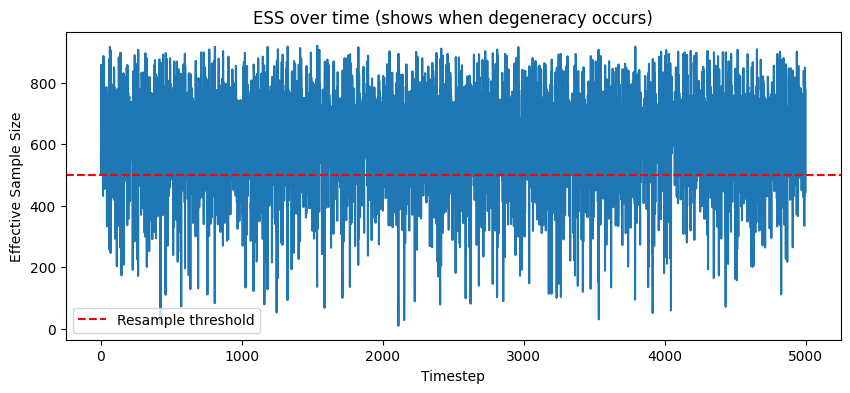

In [15]:
diagnostics = pf.get_diagnostics()
plt.figure(figsize=(10, 4))
plt.plot(diagnostics['ess'])
plt.axhline(y=pf.n_particles * pf.resample_threshold, color='r', linestyle='--', label='Resample threshold')
plt.xlabel('Timestep')
plt.ylabel('Effective Sample Size')
plt.title('ESS over time (shows when degeneracy occurs)')
plt.legend()

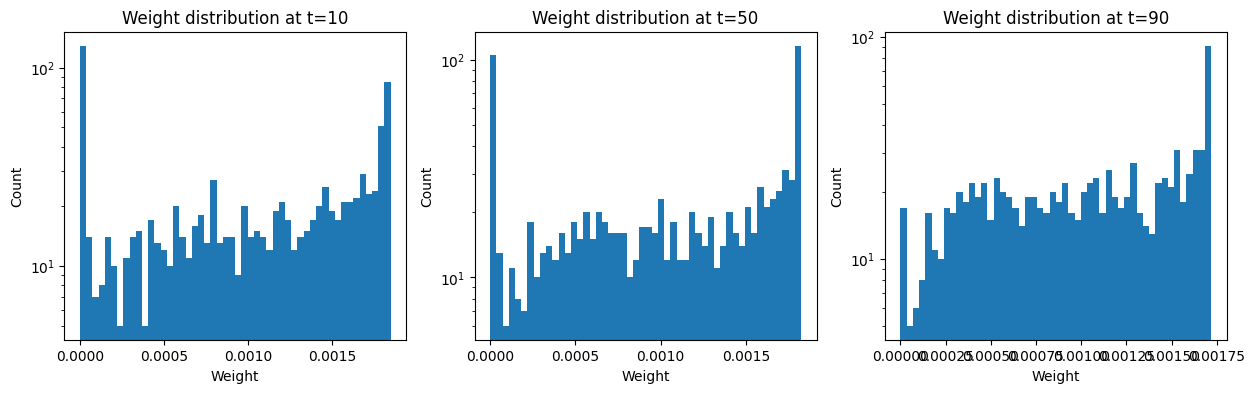

In [16]:
# Capture weights at selected timesteps (modify your filter to save this)
weights_at_timestep = diagnostics['weights_history']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, t in enumerate([10, 50, 90]):  # Early, middle, late
    axes[i].hist(weights_at_timestep[t], bins=50)
    axes[i].set_title(f'Weight distribution at t={t}')
    axes[i].set_xlabel('Weight')
    axes[i].set_ylabel('Count')
    axes[i].set_yscale('log')  # Log scale to see the tail

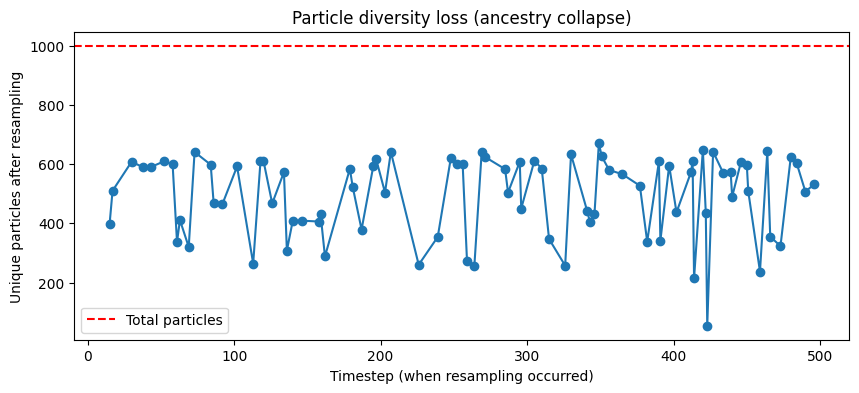

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(diagnostics['resampled_at'], diagnostics['n_unique'], 'o-')
plt.axhline(y=pf.n_particles, color='r', linestyle='--', label='Total particles')
plt.xlabel('Timestep (when resampling occurred)')
plt.ylabel('Unique particles after resampling')
plt.title('Particle diversity loss (ancestry collapse)')
plt.legend()

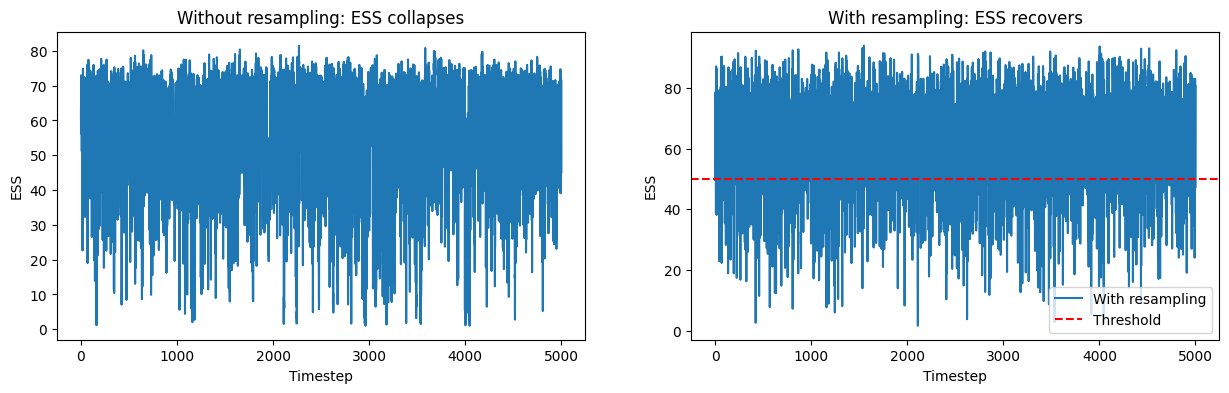

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Run WITHOUT resampling (set threshold = 0)
pf_no_resample = ParticleFilter(model_sv, n_particles=100, resample_threshold=0)
pf_no_resample.filter(observations_sv)
diag_no = pf_no_resample.get_diagnostics()

# Run WITH resampling
pf_resample = ParticleFilter(model_sv, n_particles=100, resample_threshold=0.5)
pf_resample.filter(observations_sv)
diag_yes = pf_resample.get_diagnostics()

ax1.plot(diag_no['ess'], label='No resampling')
ax1.set_title('Without resampling: ESS collapses')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('ESS')

ax2.plot(diag_yes['ess'], label='With resampling')
ax2.axhline(y=50, color='r', linestyle='--', label='Threshold')
ax2.set_title('With resampling: ESS recovers')
ax2.set_xlabel('Timestep')
ax2.set_ylabel('ESS')
ax2.legend()

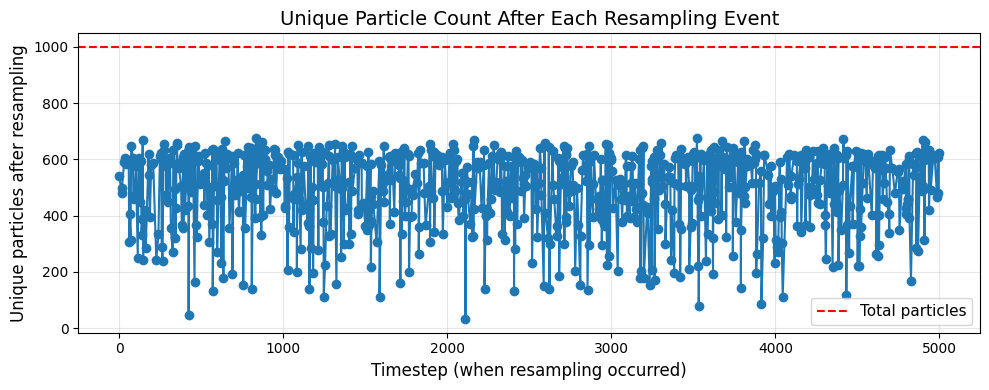

In [18]:
# Get diagnostics from the particle filter
diagnostics = pf.get_diagnostics()

# Plot unique particle count after each resampling event
plt.figure(figsize=(10, 4))
plt.plot(diagnostics['resampled_at'], diagnostics['n_unique'], 'o-', linewidth=1.5, markersize=6)
plt.axhline(y=pf.n_particles, color='r', linestyle='--', label='Total particles', linewidth=1.5)
plt.xlabel('Timestep (when resampling occurred)', fontsize=12)
plt.ylabel('Unique particles after resampling', fontsize=12)
plt.title('Unique Particle Count After Each Resampling Event', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
class NonKalmanExperiment:
    """
    Class for running non-Kalman filter experiments with standardized plotting methods.
    
    Inputs:
        model: StateSpaceModel instance
        T: Number of time steps
        random_state: numpy random generator, optional
    """
    
    def __init__(self, model, T=500, random_state=None):
        self.model = model
        self.T = T
        self.random_state = random_state if random_state is not None else np.random.default_rng(42)
        
        # State dimension
        self.nx = model.state_dim
        
        # Initialize flags
        self._data_generated = False
        self._filters_run = {}
        
        # Initialize storage variables
        self.true_states = None
        self.observations = None
        self.filter_results = {}  # Store results for each filter: {name: {'means': ..., 'covs': ..., 'filter': ..., 'errors': ..., 'error_norms': ..., 'uncertainty_norms': ...}}
    
    def generate_data(self):
        """Generate true states and observations from the model."""
        from models import generate_data
        self.true_states, self.observations = generate_data(self.model, self.T, self.random_state)
        self._data_generated = True
    
    def get_observations(self):
        """Return observations."""
        if not self._data_generated:
            raise ValueError("Data must be generated first. Call generate_data().")
        return self.observations
    
    def run_filter(self, filter_instance, filter_name):
        """
        Run a filter on the observations.
        
        Args:
            filter_instance: Filter instance (EKF, UKF, PF, etc.)
            filter_name: Name/label for this filter (e.g., 'EKF', 'UKF', 'PF')
        """
        if not self._data_generated:
            raise ValueError("Data must be generated first. Call generate_data() before run_filter().")
        
        if not hasattr(filter_instance, 'filter'):
            raise ValueError(f"Filter {filter_name} does not have a filter() method.")
        
        # Run filter (handles different filter interfaces)
        # Try with random_state first (for ParticleFilter, Flow filters)
        try:
            means, covs = filter_instance.filter(self.observations, random_state=self.random_state)
        except TypeError:
            # If that fails, try without random_state (for EKF, UKF)
            try:
                means, covs = filter_instance.filter(self.observations)
            except Exception as e:
                raise ValueError(f"Failed to run filter {filter_name}: {e}")
        
        # Compute errors
        errors = means - self.true_states
        error_norms = np.linalg.norm(errors, axis=1)
        uncertainty_norms = np.sqrt(np.trace(covs, axis1=1, axis2=2))
        
        # Store results
        self.filter_results[filter_name] = {
            'means': means,
            'covs': covs,
            'filter': filter_instance,
            'errors': errors,
            'error_norms': error_norms,
            'uncertainty_norms': uncertainty_norms
        }
        self._filters_run[filter_name] = True
    
    def plot1_true_vs_estimated_with_confidence(self, filter1=None, filter2=None, filter3=None):
        """
        Plot 1: True vs Estimated states with confidence level (error bar version).
        Works only for 1D data. Can compare up to 3 filters.
        
        Args:
            filter1, filter2, filter3: Filter names (keys in filter_results) - used as display names
        """
        if self.nx != 1:
            raise ValueError("Plot 1 only works for 1D data (state_dim = 1)")
        
        filters_to_plot = []
        colors = ['b', 'r', 'g']
        
        for f, c in zip([filter1, filter2, filter3], colors):
            if f is not None and f in self.filter_results:
                filters_to_plot.append(f)
        
        if len(filters_to_plot) == 0:
            raise ValueError("At least one filter must be specified and run.")
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        time_steps = np.arange(self.T)
        
        # Plot true state
        ax.plot(time_steps, self.true_states[:, 0], 'k-', label='True state', linewidth=2.5)
        
        # Plot each filter
        for f_name, color in zip(filters_to_plot, colors[:len(filters_to_plot)]):
            result = self.filter_results[f_name]
            means = result['means']
            covs = result['covs']
            
            # Extract standard deviation
            if covs.shape[1] == 1:
                std = np.sqrt(covs[:, 0, 0])
            else:
                std = np.sqrt(np.trace(covs, axis1=1, axis2=2))
            
            ax.plot(time_steps, means[:, 0], '--', color=color, label=f_name, linewidth=1.5, alpha=0.8)
            ax.fill_between(
                time_steps,
                means[:, 0] - 2*std,
                means[:, 0] + 2*std,
                alpha=0.2, color=color, label=f'{f_name} ±2σ'
            )
        
        ax.set_xlabel('Time Step', fontsize=12)
        ax.set_ylabel('State', fontsize=12)
        ax.set_title('True vs Estimated State with Confidence Intervals', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot2_true_vs_estimated_with_observations(self, filter1=None, filter2=None, filter3=None):
        """
        Plot 2: True vs Estimated states with observations.
        Works only for 1D data. Can compare up to 3 filters.
        
        Args:
            filter1, filter2, filter3: Filter names (keys in filter_results) - used as display names
        """
        if self.nx != 1:
            raise ValueError("Plot 2 only works for 1D data (state_dim = 1)")
        
        filters_to_plot = []
        colors = ['b', 'r', 'g']
        
        for f, c in zip([filter1, filter2, filter3], colors):
            if f is not None and f in self.filter_results:
                filters_to_plot.append(f)
        
        if len(filters_to_plot) == 0:
            raise ValueError("At least one filter must be specified and run.")
        
        fig, ax = plt.subplots(1, 1, figsize=(14, 6))
        time_steps = np.arange(self.T)
        
        # Plot observations
        ax.plot(time_steps, self.observations[:, 0], 'g.', label='Observations', markersize=1, alpha=0.4)
        
        # Plot true state
        ax.plot(time_steps, self.true_states[:, 0], 'k-', label='True state', linewidth=2)
        
        # Plot each filter
        for f_name, color in zip(filters_to_plot, colors[:len(filters_to_plot)]):
            result = self.filter_results[f_name]
            means = result['means']
            ax.plot(time_steps, means[:, 0], '--', color=color, label=f_name, linewidth=1.5, alpha=0.8)
        
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
        ax.set_title('Observations vs True/Estimated State')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot3_absolute_error_with_2sigma(self, filter1=None, filter2=None, filter3=None):
        """
        Plot 3: Absolute error with 2 sigma bound.
        Works for any dimension. Can compare up to 3 filters.
        
        Args:
            filter1, filter2, filter3: Filter names (keys in filter_results) - used as display names
        """
        filters_to_plot = []
        colors = ['b', 'r', 'g']
        
        for f, c in zip([filter1, filter2, filter3], colors):
            if f is not None and f in self.filter_results:
                filters_to_plot.append(f)
        
        if len(filters_to_plot) == 0:
            raise ValueError("At least one filter must be specified and run.")
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        time_steps = np.arange(self.T)
        
        # Plot each filter
        for f_name, color in zip(filters_to_plot, colors[:len(filters_to_plot)]):
            result = self.filter_results[f_name]
            error_norms = result['error_norms']
            uncertainty_norms = result['uncertainty_norms']
            
            ax.plot(time_steps, error_norms, '-', color=color, linewidth=1.5, 
                   label=f'{f_name} error norm', alpha=0.8)
            ax.plot(time_steps, 2*uncertainty_norms, '--', color=color, linewidth=1.5, 
                   label=f'{f_name} 2σ bound', alpha=0.6)
        
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Error Norm')
        ax.set_title('Error vs Uncertainty: Error should be within 2σ bound')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_pf_ess(self, filter_name):
        """
        Plot effective sample size (ESS) over time for particle filter.
        
        Args:
            filter_name: Name of the particle filter (must be in filter_results)
        """
        if filter_name not in self.filter_results:
            raise ValueError(f"Filter '{filter_name}' not found. Run filter first.")
        
        filter_instance = self.filter_results[filter_name]['filter']
        
        if not hasattr(filter_instance, 'get_diagnostics'):
            raise ValueError(f"Filter '{filter_name}' does not support diagnostics (not a particle filter).")
        
        diagnostics = filter_instance.get_diagnostics()
        
        if 'ess' not in diagnostics:
            raise ValueError(f"Filter '{filter_name}' does not provide ESS diagnostics.")
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        time_steps = np.arange(len(diagnostics['ess']))
        
        ax.plot(time_steps, diagnostics['ess'], 'b-', linewidth=1.5, label='Effective Sample Size')
        
        # Plot resample threshold if available
        if hasattr(filter_instance, 'n_particles') and hasattr(filter_instance, 'resample_threshold'):
            threshold = filter_instance.n_particles * filter_instance.resample_threshold
            ax.axhline(y=threshold, color='r', linestyle='--', linewidth=1.5, 
                      label=f'Resample threshold ({threshold:.1f})')
        
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Effective Sample Size')
        ax.set_title('ESS over time (shows when degeneracy occurs)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_pf_unique_particles(self, filter_name):
        """
        Plot unique particle count after each resampling event.
        
        Args:
            filter_name: Name of the particle filter (must be in filter_results)
        """
        if filter_name not in self.filter_results:
            raise ValueError(f"Filter '{filter_name}' not found. Run filter first.")
        
        filter_instance = self.filter_results[filter_name]['filter']
        
        if not hasattr(filter_instance, 'get_diagnostics'):
            raise ValueError(f"Filter '{filter_name}' does not support diagnostics (not a particle filter).")
        
        diagnostics = filter_instance.get_diagnostics()
        
        if 'resampled_at' not in diagnostics or 'n_unique' not in diagnostics:
            raise ValueError(f"Filter '{filter_name}' does not provide resampling diagnostics.")
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        ax.plot(diagnostics['resampled_at'], diagnostics['n_unique'], 'o-', 
               linewidth=1.5, markersize=6, label='Unique particles after resampling')
        
        if hasattr(filter_instance, 'n_particles'):
            ax.axhline(y=filter_instance.n_particles, color='r', linestyle='--', 
                      linewidth=1.5, label=f'Total particles ({filter_instance.n_particles})')
        
        ax.set_xlabel('Timestep (when resampling occurred)', fontsize=12)
        ax.set_ylabel('Unique particles after resampling', fontsize=12)
        ax.set_title('Particle diversity loss (ancestry collapse)', fontsize=14)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_pf_resampling_comparison(self, filter_with_name, filter_without_name):
        """
        Compare particle filter performance with and without resampling.
        
        Args:
            filter_with_name: Name of filter with resampling
            filter_without_name: Name of filter without resampling
        """
        for name in [filter_with_name, filter_without_name]:
            if name not in self.filter_results:
                raise ValueError(f"Filter '{name}' not found. Run filter first.")
        
        filter_with = self.filter_results[filter_with_name]['filter']
        filter_without = self.filter_results[filter_without_name]['filter']
        
        for f, name in [(filter_with, filter_with_name), (filter_without, filter_without_name)]:
            if not hasattr(f, 'get_diagnostics'):
                raise ValueError(f"Filter '{name}' does not support diagnostics (not a particle filter).")
        
        diag_with = filter_with.get_diagnostics()
        diag_without = filter_without.get_diagnostics()
        
        if 'ess' not in diag_with or 'ess' not in diag_without:
            raise ValueError("Both filters must provide ESS diagnostics.")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Without resampling
        time_steps = np.arange(len(diag_without['ess']))
        ax1.plot(time_steps, diag_without['ess'], 'b-', linewidth=1.5, label='No resampling')
        ax1.set_title('Without resampling: ESS collapses', fontsize=12)
        ax1.set_xlabel('Timestep')
        ax1.set_ylabel('ESS')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # With resampling
        time_steps = np.arange(len(diag_with['ess']))
        ax2.plot(time_steps, diag_with['ess'], 'g-', linewidth=1.5, label='With resampling')
        if hasattr(filter_with, 'n_particles') and hasattr(filter_with, 'resample_threshold'):
            threshold = filter_with.n_particles * filter_with.resample_threshold
            ax2.axhline(y=threshold, color='r', linestyle='--', linewidth=1.5, 
                       label=f'Threshold ({threshold:.1f})')
        ax2.set_title('With resampling: ESS recovers', fontsize=12)
        ax2.set_xlabel('Timestep')
        ax2.set_ylabel('ESS')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_pf_weights_distribution(self, filter_name, timesteps=None):
        """
        Plot weight distribution at selected timesteps.
        
        Args:
            filter_name: Name of the particle filter (must be in filter_results)
            timesteps: List of timesteps to plot. If None, uses [10, 50, 90] or similar
        """
        if filter_name not in self.filter_results:
            raise ValueError(f"Filter '{filter_name}' not found. Run filter first.")
        
        filter_instance = self.filter_results[filter_name]['filter']
        
        if not hasattr(filter_instance, 'get_diagnostics'):
            raise ValueError(f"Filter '{filter_name}' does not support diagnostics (not a particle filter).")
        
        diagnostics = filter_instance.get_diagnostics()
        
        if 'weights_history' not in diagnostics:
            raise ValueError(f"Filter '{filter_name}' does not provide weights history.")
        
        weights_history = diagnostics['weights_history']
        T = len(weights_history)
        
        if timesteps is None:
            # Default: early, middle, late
            timesteps = [min(10, T-1), min(T//2, T-1), min(max(90, T-10), T-1)]
            timesteps = sorted(list(set(timesteps)))  # Remove duplicates and sort
        
        # Filter valid timesteps
        valid_timesteps = [t for t in timesteps if 0 <= t < T]
        if len(valid_timesteps) == 0:
            raise ValueError(f"No valid timesteps. T={T}, requested={timesteps}")
        
        n_plots = len(valid_timesteps)
        fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 4))
        
        if n_plots == 1:
            axes = [axes]
        
        for i, t in enumerate(valid_timesteps):
            axes[i].hist(weights_history[t], bins=50, edgecolor='black', alpha=0.7)
            axes[i].set_title(f'Weight distribution at t={t}', fontsize=12)
            axes[i].set_xlabel('Weight', fontsize=11)
            axes[i].set_ylabel('Count', fontsize=11)
            axes[i].set_yscale('log')  # Log scale to see the tail
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
